In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import pickle
from PIL import Image

# Download necessary NLTK data
nltk.download('punkt')

2024-07-13 00:49:54.889571: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 00:49:55.152213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 00:49:55.276390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 00:49:55.277186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 00:49:55.489549: I tensorflow/core/platform/cpu_feature_gua

True

In [2]:

# Load the ResNet50 model for feature extraction
resnet_model = ResNet50(weights='imagenet')
feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)
# feature_extractor.summary()

2024-07-13 00:50:00.243645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:50:00.475829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:50:00.475907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:50:00.481468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 00:50:00.481548: I external/local_xla/xla/stream_executor

In [3]:
def extract_batch_features(image_paths, model):
    batch_images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        batch_images.append(img)
    batch_images = np.array(batch_images)
    batch_features = model.predict(batch_images)
    return batch_features

def extract_all_features(image_dir, model, batch_size=64):
    features = {}
    image_paths = []
    image_ids = []

    for img_name in os.listdir(image_dir):
        if img_name.lower().endswith('.jpg'):
            img_path = os.path.join(image_dir, img_name)
            img_id = img_name.split('.')[0]
            image_paths.append(img_path)
            image_ids.append(img_id)

    num_images = len(image_paths)
    num_batches = num_images // batch_size + (1 if num_images % batch_size != 0 else 0)

    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = min(start + batch_size, num_images)
        batch_paths = image_paths[start:end]
        batch_ids = image_ids[start:end]
        batch_features = extract_batch_features(batch_paths, model)

        for i, img_id in enumerate(batch_ids):
            features[img_id] = batch_features[i]

        print(f"Processed batch {batch_idx + 1}/{num_batches}")

    return features

In [4]:
# Directory containing images
image_dir = 'flickr30k/Images'

# Load pre-trained ResNet50 model
feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features for all images in the directory
features = extract_all_features(image_dir, feature_extractor)
print(f"Number of images in features: {len(features)}")

I0000 00:00:1720828206.545407     601 service.cc:145] XLA service 0x7f63d4018570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720828206.545470     601 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-13 00:50:06.671953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-13 00:50:07.306272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


I0000 00:00:1720828212.259340     601 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processed batch 1/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 2/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 3/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Processed batch 4/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 5/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 6/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Processed batch 7/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Processed batch 8/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 9/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 10/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Processed batch 11/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Processed batch 12/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 13/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Processed batch 14/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Processed batch 15/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Processed batch 16/497
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Processed batch 17/497
2/2 ━━━━━━

In [5]:
# Print dimensions of features for the top 10 images
print(f"Number of images in features: {len(features)}")

# Get the first 10 image IDs
top_10_image_ids = list(features.keys())[:10]

# Iterate over top 10 keys and print shape
for img_id in top_10_image_ids:
    feature_vector = features[img_id]
    print(f"Image ID: {img_id}, Feature shape: {feature_vector.shape}")



Number of images in features: 31783
Image ID: 4358945591, Feature shape: (2048,)
Image ID: 3106481126, Feature shape: (2048,)
Image ID: 4718154276, Feature shape: (2048,)
Image ID: 1594038143, Feature shape: (2048,)
Image ID: 2548777800, Feature shape: (2048,)
Image ID: 2836696661, Feature shape: (2048,)
Image ID: 6505027097, Feature shape: (2048,)
Image ID: 3603357375, Feature shape: (2048,)
Image ID: 2282530092, Feature shape: (2048,)
Image ID: 1660269454, Feature shape: (2048,)


In [6]:
captions_file = 'flickr30k/captions.txt'  # Adjust the path as necessary
captions = pd.read_csv(captions_file, delimiter=',', header=0)
captions.columns = ['image', 'caption']

In [8]:
# Process captions
def preprocess_captions(captions):
    captions = captions.dropna(subset=['caption'])  # Remove rows with NaN comments
    captions['caption'] = captions['caption'].apply(lambda x: 'startseq ' + str(x).lower().strip() + ' endseq')
    captions['image'] = captions['image'].apply(lambda x: x.split('.')[0].strip())
    return captions

captions = preprocess_captions(captions)
print("Caption image IDs:", captions['image'].unique()[:10])

Caption image IDs: ['1000092795' '10002456' '1000268201' '1000344755' '1000366164'
 '1000523639' '1000919630' '10010052' '1001465944' '1001545525']


In [9]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions['caption'].values)
vocab_size = len(tokenizer.word_index) + 1

# Convert captions to sequences
sequences = tokenizer.texts_to_sequences(captions['caption'].values)
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [10]:
def define_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256, return_sequences=False)(se2)  # Ensure right-padded sequences
    
    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Compile the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model



print(f"Vocabulary Size: {vocab_size}")
print(f"Maximum sequence length: {max_length}")
captioning_model = define_model(vocab_size, max_length)
captioning_model.summary()

Vocabulary Size: 18315
Maximum sequence length: 82


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 82)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 82, 256)   │  4,688,640 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 82, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 82)        │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18315)     │  4,706,955 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,511,243 (40.10 MB)

 Trainable params: 10,511,243 (40.10 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Pad sequences
def pad_caption_sequences(captions, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

In [12]:
def data_generator(features, captions, tokenizer, max_length, vocab_size, batch_size):
    while True:
        for i in range(0, len(captions), batch_size):
            X1, X2, y = [], [], []
            for j in range(i, min(len(captions), i + batch_size)):
                img_id = captions['image'].iloc[j]
                if img_id in features:
                    img_features = features[img_id]
                    seq = tokenizer.texts_to_sequences([captions['caption'].iloc[j]])[0]
                    for k in range(1, len(seq)):
                        in_seq, out_seq = seq[:k], seq[k]
                        in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]  # Right-padded
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        X1.append(img_features)
                        X2.append(in_seq)
                        y.append(out_seq)

            X1 = np.array(X1)
            X2 = np.array(X2)
            y = np.array(y)
            yield ((X1, X2), y)


In [13]:
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Set TensorFlow to only use the first GPU if there are multiple
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print("GPU available:", gpus)
else:
    print("No GPU available, training on CPU.")


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# batch_size = 32
# steps = len(captions) // batch_size
# generator = data_generator(features, captions, tokenizer, max_length, vocab_size, batch_size)


# captioning_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [24]:
# Set batch size and steps
batch_size = 32

In [25]:
# steps = len(captions) // batch_size

# # Configure early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# # Train the model with early stopping
# generator = data_generator(features, captions, tokenizer, max_length, vocab_size, batch_size)
# history = captioning_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[early_stopping])

In [ ]:

# Define train and validation sizes (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(captions))
val_size = len(captions) - train_size

# Split data into training and validation sets
train_captions = captions[:train_size]
val_captions = captions[train_size:]

# Create generators for training and validation data
train_generator = data_generator(features, train_captions, tokenizer, max_length, vocab_size, batch_size)
val_generator = data_generator(features, val_captions, tokenizer, max_length, vocab_size, batch_size)

# Calculate steps per epoch for training and validation
train_steps = len(train_captions) // batch_size
val_steps = len(val_captions) // batch_size

# Configure early stopping callback to monitor training loss
early_stopping = EarlyStopping(monitor='loss', patience=6, verbose=1, restore_best_weights=True)

# Train the model with early stopping and validation data
history = captioning_model.fit(train_generator,
                               epochs=100,
                               steps_per_epoch=train_steps,
                               validation_data=val_generator,
                               validation_steps=val_steps,
                               verbose=1,
                               callbacks=[early_stopping])


Epoch 1/100
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 278s 70ms/step - loss: 2.1963 - val_loss: 3.8296
Epoch 2/100
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 266s 67ms/step - loss: 2.1934 - val_loss: 3.8442
Epoch 3/100
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 272s 68ms/step - loss: 2.1942 - val_loss: 3.8609
Epoch 4/100
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 269s 68ms/step - loss: 2.1966 - val_loss: 3.8699
Epoch 5/100
2209/3972 ━━━━━━━━━━━━━━━━━━━━ 1:33 53ms/step - loss: 2.1969

In [ ]:
# Save the tokenizer
tokenizer_file_path = 'testing/tokenizerfinalv2.pkl'
with open(tokenizer_file_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Save the trained model
captioning_model.save('testing/image_captioning_model_finalv2.keras')
print("Model saved successfully!")

to generate caption for an image

In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from PIL import Image
import numpy as np
import os
import pickle

# Load the saved model
model = load_model('image_captioning_model_final.keras')

# Function to preprocess images
def extract_features(img_path):
    model_resnet = ResNet50(weights='imagenet')
    model = tf.keras.Model(inputs=model_resnet.input, outputs=model_resnet.layers[-2].output)

    img = Image.open(img_path).resize((224, 224))
    img = np.array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    features = model.predict(img)
    return features

# Function to generate caption
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')  # Ensure right-padding
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

# Function to map predicted word index to word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Load and preprocess the new image
img_path = 'dogggy.jpeg'
photo = extract_features(img_path)
tokenizer_file_path = 'tokenizerfinal.pkl'
with open(tokenizer_file_path, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# Generate caption
max_length = 82
caption = generate_caption(model, tokenizer, photo, max_length)
print("Generated Caption:", caption)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Generated Caption: startseq startseq a brown dog is running through a grassy field endseq


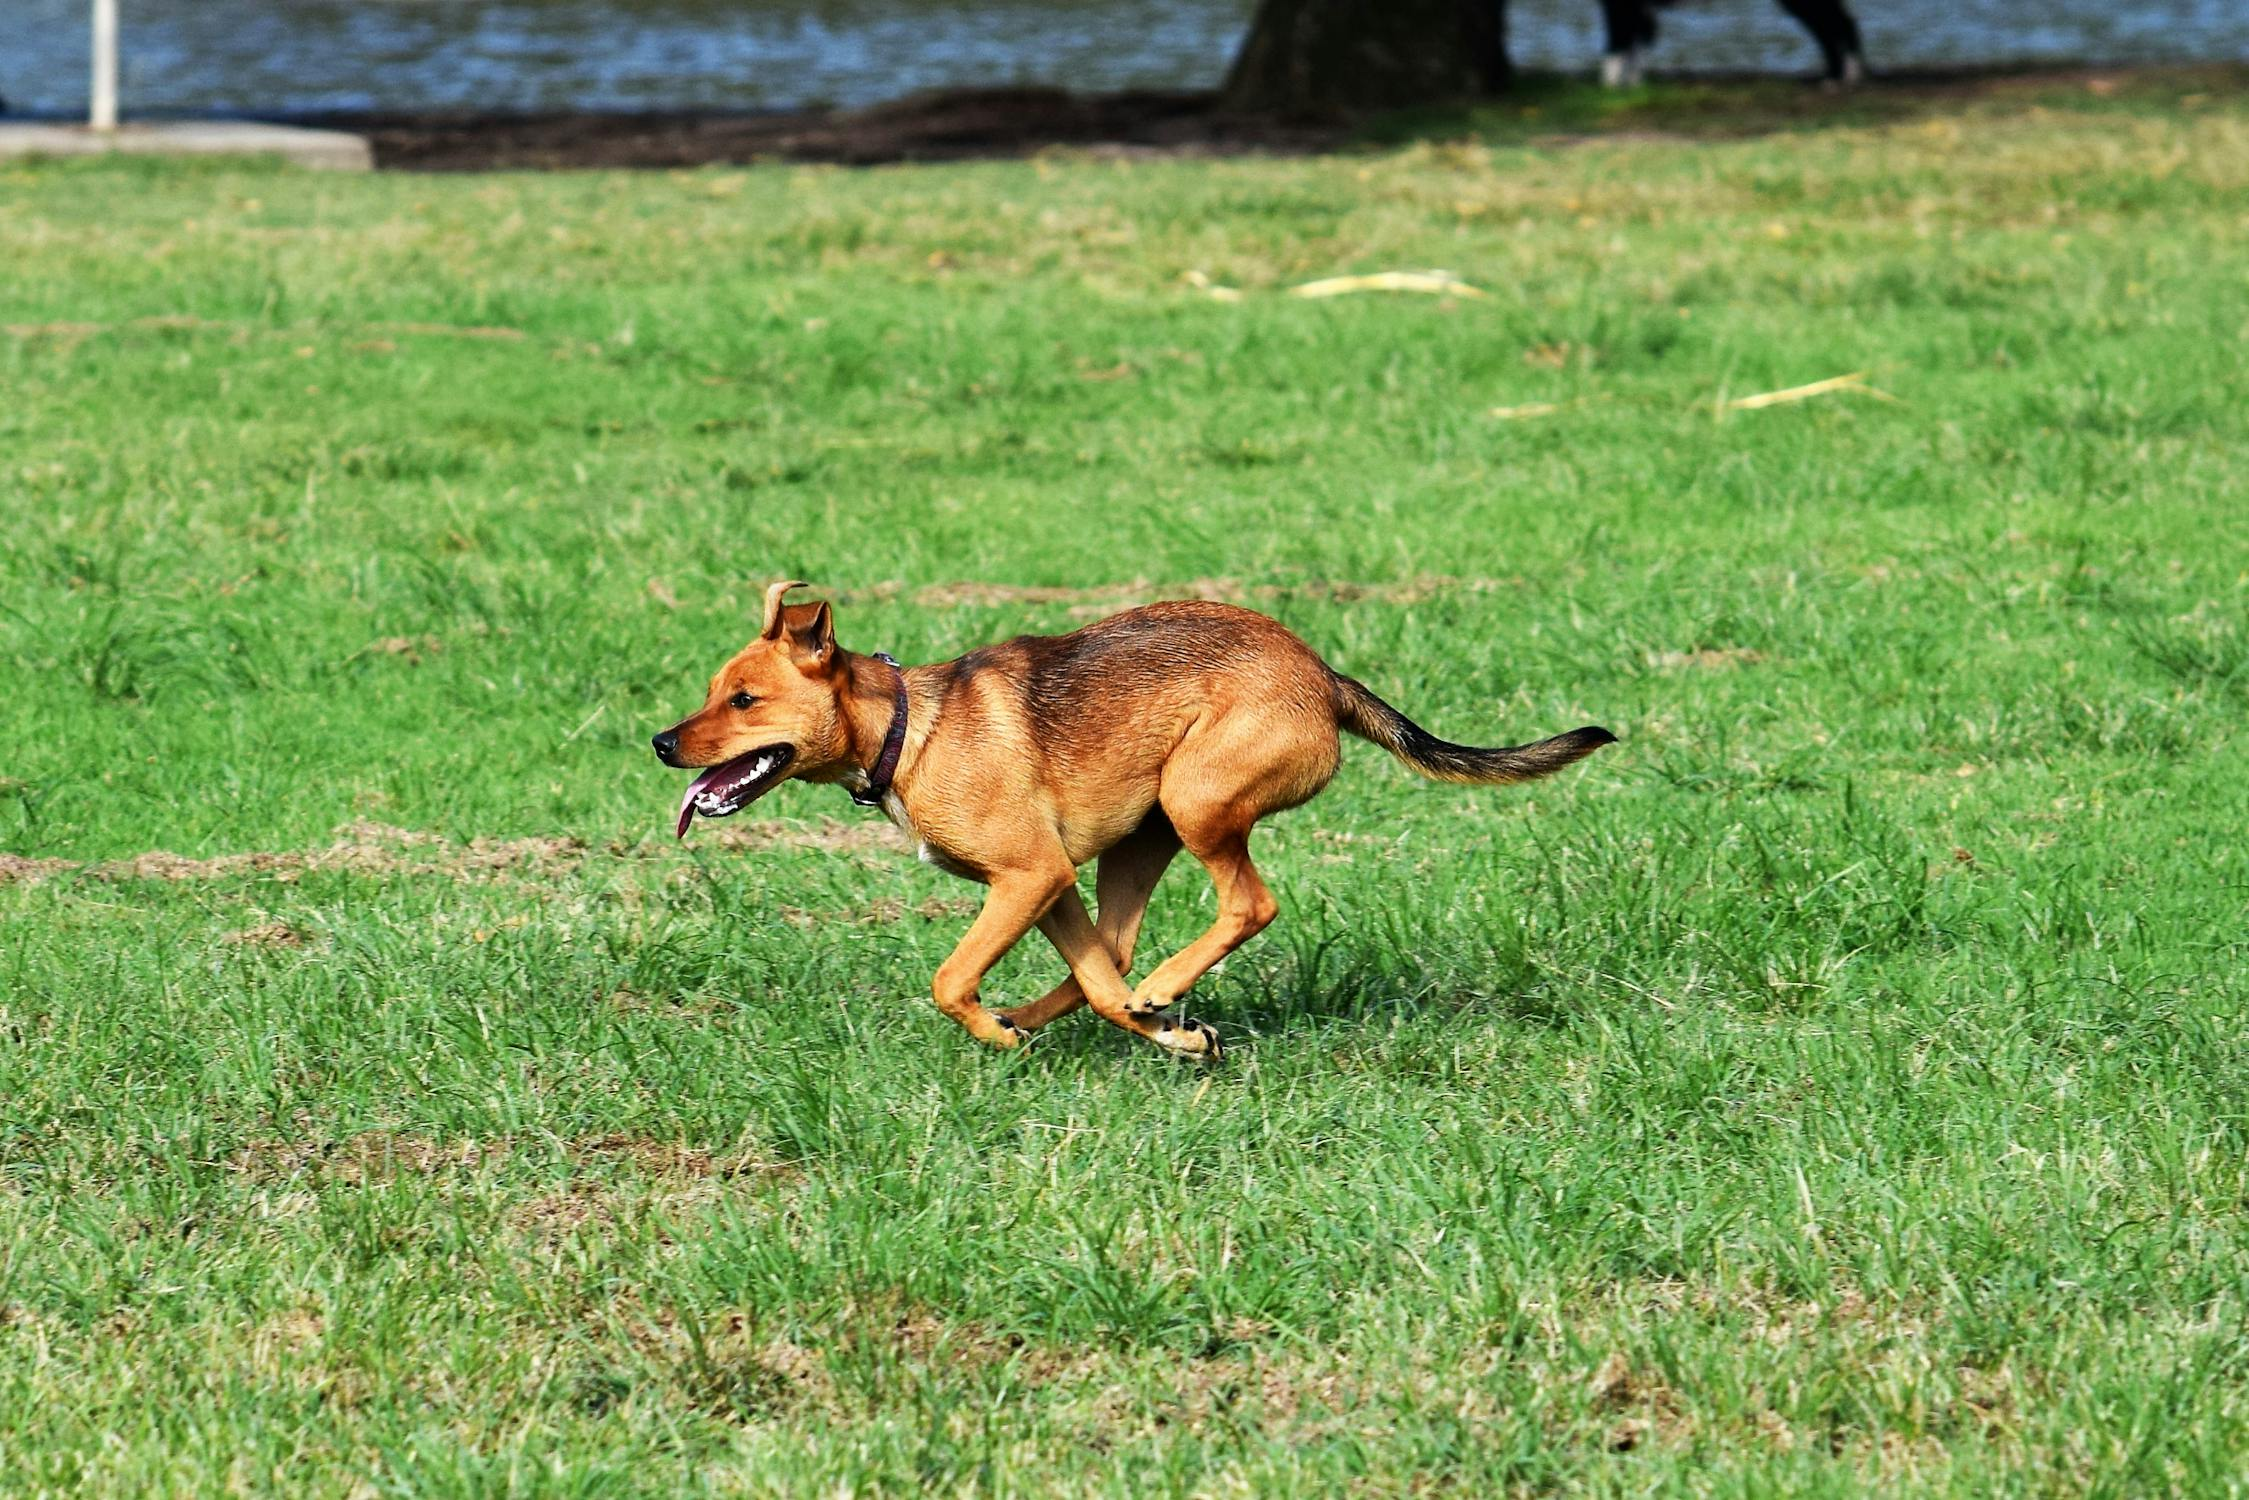

In [1]:
from IPython.display import Image
Image(filename='dooggy.jpeg')

**Generated Caption:  a brown dog is running through a grassy field.**